<a href="https://colab.research.google.com/github/bhargav23/EVA4/blob/master/S11/EVA_S11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch
import torchvision
import torchvision.transforms as transforms


import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import sys
sys.path.append('/content/drive/My Drive/EVA/S7')

In [0]:
import albumentations as A
from evaAlbumentations import AlbumentationTransforms
import numpy as np
import cv2
means = (0.49139968, 0.48215841, 0.44653091)
stdevs = (0.24703223, 0.24348513, 0.26158784)
train_transforms = AlbumentationTransforms(
    [ A.PadIfNeeded(40,40,border_mode=cv2.BORDER_CONSTANT, value=np.array(means)*255),
      A.RandomCrop(32, 32,  always_apply=True),
      A.HorizontalFlip(),
      A.Normalize(mean=means, std=stdevs),
      A.Cutout(num_holes=1, max_h_size=8, max_w_size=8, p=1)])




test_transforms = AlbumentationTransforms([A.Normalize(mean=means, std=stdevs)])

In [5]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=train_transforms)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=test_transforms)

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [0]:
import evadataloader
dataloader = evadataloader.DataLoader()

trainloader = dataloader.load(trainset)
testloader = dataloader.load(testset)

Let us show some of the training images, for fun.



torch.Size([512, 3, 32, 32])
torch.Size([512])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


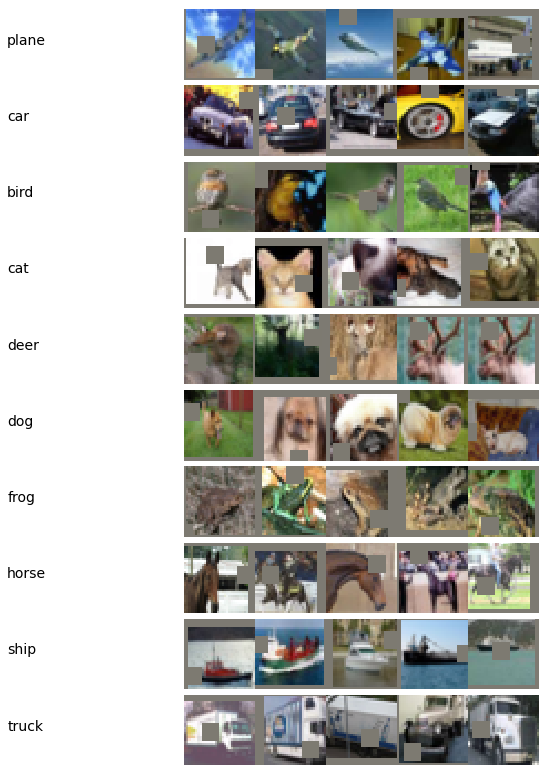

In [7]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# functions to show an image

from __future__ import print_function
def unnormalize(img):
  img = img.numpy().astype(dtype=np.float32)
  
  for i in range(img.shape[0]):
    img[i] = (img[i]*stdevs[i])+means[i]
  
  return np.transpose(img, (1,2,0))

%matplotlib inline
import matplotlib.pyplot as plt
dataiter = iter(trainloader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

num_classes = 10
 

r, c = 10, 11
n = 5
fig = plt.figure(figsize=(14,14))
fig.subplots_adjust(hspace=0.01, wspace=0.01)
for i in range(num_classes):
    idx = np.random.choice(np.where(labels[:]==i)[0], n)
    ax = plt.subplot(r, c, i*c+1)
    ax.text(-1.5, 0.5, classes[i], fontsize=14)
    plt.axis('off')
    for j in range(1, n+1):
      plt.subplot(r, c, i*c+j+1)
      plt.imshow(unnormalize(images[idx[j-1]]), interpolation='none')
      plt.axis('off')
plt.show()

In [0]:
import evamodel

net = evamodel.newResnet()

In [9]:
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = net.to(device)
summary(model, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
              ReLU-2           [-1, 64, 32, 32]               0
       BatchNorm2d-3           [-1, 64, 32, 32]             128
            Conv2d-4          [-1, 128, 32, 32]          73,856
         MaxPool2d-5          [-1, 128, 16, 16]               0
              ReLU-6          [-1, 128, 16, 16]               0
       BatchNorm2d-7          [-1, 128, 16, 16]             256
            Conv2d-8          [-1, 128, 16, 16]         147,584
       BatchNorm2d-9          [-1, 128, 16, 16]             256
             ReLU-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 128, 16, 16]         147,584
      BatchNorm2d-12          [-1, 128, 16, 16]             256
             ReLU-13          [-1, 128, 16, 16]               0
           Conv2d-14          [-1,

  pip install torch-lr-finder -v --global-option="amp"


Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


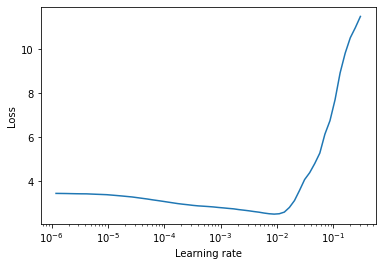

In [10]:
import sys
from torch_lr_finder import LRFinder
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-7, momentum=0.9, nesterov=True, weight_decay=1e-4)
lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
lr_finder.range_test(trainloader, end_lr=100, num_iter=100, step_mode="exp")
# Plot learning rate vs loss
lr_finder.plot()

# Reset graph
lr_finder.reset()

In [11]:
loss = lr_finder.history['loss']
lr = lr_finder.history['lr']
max_lr = lr[loss.index(min(loss))]
max_lr

0.008912509381337464

In [12]:
from torch.optim.lr_scheduler import StepLR
from torch.optim.lr_scheduler import ReduceLROnPlateau
from evascheduler import train,test
from torch.optim.lr_scheduler import OneCycleLR
L1lambda = 0
L2lambda = 0
EPOCHS = 24
model =  net.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, nesterov=True, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer,
                 max_lr=0.01,
                 total_steps=25,
                 epochs=25,
                 pct_start=0.2,
                 cycle_momentum=False,
                 base_momentum=0.85,
                 max_momentum=0.95,
                 div_factor=10.,
                 final_div_factor=1e4,
                 last_epoch=-1)

for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, trainloader, optimizer, epoch,criterion)
    scheduler.step()
    test(model, device, testloader)


  0%|          | 0/98 [00:00<?, ?it/s]

EPOCH: 0


Loss=1.3211593627929688 Batch_id=97 Accuracy=42.96: 100%|██████████| 98/98 [00:26<00:00,  3.66it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.4452, Accuracy: 5548/10000 (55.48%)

EPOCH: 1


Loss=0.9992629289627075 Batch_id=97 Accuracy=57.66: 100%|██████████| 98/98 [00:28<00:00,  3.46it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.3647, Accuracy: 6353/10000 (63.53%)

EPOCH: 2


Loss=0.7979516386985779 Batch_id=97 Accuracy=62.71: 100%|██████████| 98/98 [00:28<00:00,  3.49it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.3016, Accuracy: 6984/10000 (69.84%)

EPOCH: 3


  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.2614, Accuracy: 7386/10000 (73.86%)

EPOCH: 4


Loss=0.7518728971481323 Batch_id=97 Accuracy=73.68: 100%|██████████| 98/98 [00:28<00:00,  3.50it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.2282, Accuracy: 7718/10000 (77.18%)

EPOCH: 5


Loss=0.6657179594039917 Batch_id=97 Accuracy=78.93: 100%|██████████| 98/98 [00:27<00:00,  3.51it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.2098, Accuracy: 7902/10000 (79.02%)

EPOCH: 6


Loss=0.6246639490127563 Batch_id=97 Accuracy=81.80: 100%|██████████| 98/98 [00:27<00:00,  3.53it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.1874, Accuracy: 8126/10000 (81.26%)

EPOCH: 7


Loss=0.4423786401748657 Batch_id=97 Accuracy=83.78: 100%|██████████| 98/98 [00:27<00:00,  3.51it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.1751, Accuracy: 8249/10000 (82.49%)

EPOCH: 8


Loss=0.4824467599391937 Batch_id=97 Accuracy=85.90: 100%|██████████| 98/98 [00:28<00:00,  3.50it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.1661, Accuracy: 8339/10000 (83.39%)

EPOCH: 9


Loss=0.4621807634830475 Batch_id=97 Accuracy=87.06: 100%|██████████| 98/98 [00:27<00:00,  3.50it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.1619, Accuracy: 8381/10000 (83.81%)

EPOCH: 10


Loss=0.30565014481544495 Batch_id=97 Accuracy=88.52: 100%|██████████| 98/98 [00:27<00:00,  3.53it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.1398, Accuracy: 8602/10000 (86.02%)

EPOCH: 11


Loss=0.353535920381546 Batch_id=97 Accuracy=89.62: 100%|██████████| 98/98 [00:27<00:00,  3.53it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.1370, Accuracy: 8630/10000 (86.30%)

EPOCH: 12


Loss=0.3047911524772644 Batch_id=97 Accuracy=90.53: 100%|██████████| 98/98 [00:27<00:00,  3.51it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.1212, Accuracy: 8788/10000 (87.88%)

EPOCH: 13


Loss=0.2557844817638397 Batch_id=97 Accuracy=91.38: 100%|██████████| 98/98 [00:27<00:00,  3.51it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.1277, Accuracy: 8723/10000 (87.23%)

EPOCH: 14


Loss=0.21251890063285828 Batch_id=97 Accuracy=92.10: 100%|██████████| 98/98 [00:27<00:00,  3.51it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.1224, Accuracy: 8776/10000 (87.76%)

EPOCH: 15


Loss=0.2565273642539978 Batch_id=97 Accuracy=92.78: 100%|██████████| 98/98 [00:28<00:00,  3.49it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.1174, Accuracy: 8826/10000 (88.26%)

EPOCH: 16


Loss=0.16597993671894073 Batch_id=97 Accuracy=93.71: 100%|██████████| 98/98 [00:27<00:00,  3.51it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.1123, Accuracy: 8877/10000 (88.77%)

EPOCH: 17


Loss=0.13564331829547882 Batch_id=97 Accuracy=94.04: 100%|██████████| 98/98 [00:27<00:00,  3.51it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.1092, Accuracy: 8908/10000 (89.08%)

EPOCH: 18


Loss=0.20366264879703522 Batch_id=97 Accuracy=94.37: 100%|██████████| 98/98 [00:27<00:00,  3.50it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.1058, Accuracy: 8942/10000 (89.42%)

EPOCH: 19


Loss=0.14550645649433136 Batch_id=97 Accuracy=95.06: 100%|██████████| 98/98 [00:28<00:00,  3.50it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.1064, Accuracy: 8936/10000 (89.36%)

EPOCH: 20


Loss=0.12986323237419128 Batch_id=97 Accuracy=95.16: 100%|██████████| 98/98 [00:27<00:00,  3.53it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.1069, Accuracy: 8931/10000 (89.31%)

EPOCH: 21


Loss=0.11717178672552109 Batch_id=97 Accuracy=95.46: 100%|██████████| 98/98 [00:27<00:00,  3.53it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.1046, Accuracy: 8954/10000 (89.54%)

EPOCH: 22


Loss=0.12340835481882095 Batch_id=97 Accuracy=95.64: 100%|██████████| 98/98 [00:27<00:00,  3.53it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.1042, Accuracy: 8958/10000 (89.58%)

EPOCH: 23


Loss=0.09143539518117905 Batch_id=97 Accuracy=95.66: 100%|██████████| 98/98 [00:27<00:00,  3.50it/s]



Test set: Average loss: 0.1034, Accuracy: 8966/10000 (89.66%)



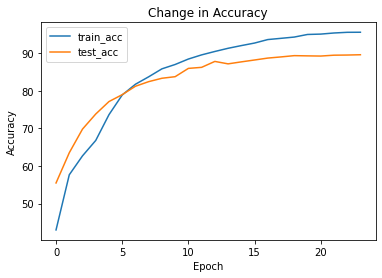

In [13]:
from evascheduler import draw_graph
draw_graph()


In [0]:
from evascheduler import get_misclassified
misclassified = get_misclassified()

25


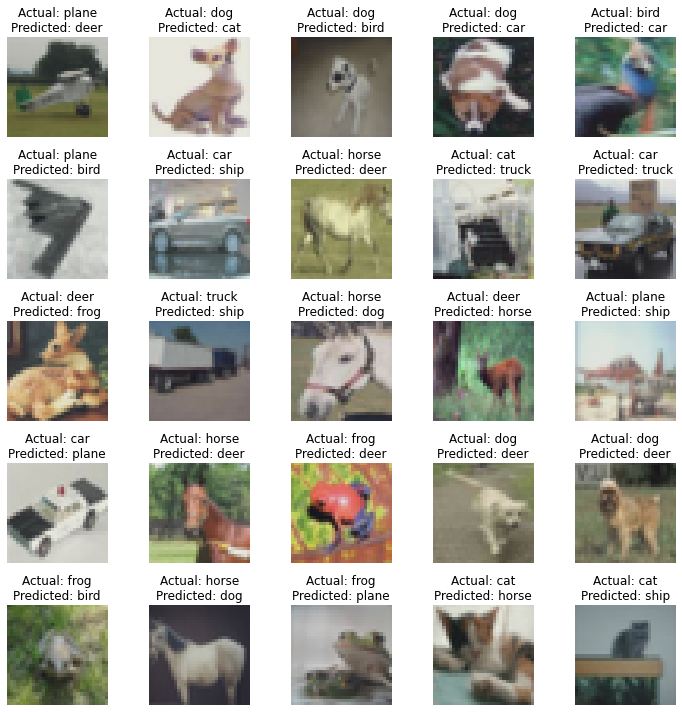

In [15]:
import utils
from utils import plot_images
plot_images(misclassified,classes,"misclassified.png")

In [0]:
model_save_name = 'models11.pt'
PATH = F"/content/drive/My Drive/EVA/S7/{model_save_name}" 
torch.save(model.state_dict(), PATH)

In [17]:
path = F"/content/drive/My Drive/EVA/S7/{model_save_name}"
model.load_state_dict(torch.load(path))

<All keys matched successfully>

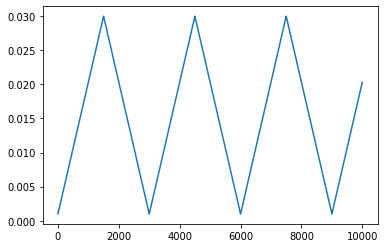

In [18]:
from utils import print_triangular_lr
num_iterations = 10000
stepsize = 1500
base_lr = 0.001
max_lr = 0.03
lr_trend = list()

for iteration in range(num_iterations):
    lr = print_triangular_lr(iteration, stepsize, base_lr, max_lr)
    lr_trend.append(lr)

plt.plot(lr_trend)